In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, recall_score, precision_score


In [2]:
class ECGDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.tensor(data.values, dtype=torch.float32).unsqueeze(1)
        self.labels = torch.tensor(labels.values.astype(np.int64), dtype=torch.long).squeeze()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]




In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
#         self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=7, stride=1, padding=1)
        self.conv1 = nn.Conv1d(1, 32, 7, 1, 1)
        
        self.conv2 = nn.Conv1d(32, 32, 5, 2, 1)
        
        self.conv3 = nn.Conv1d(32, 32, 3, 2, 0)
        self.norm3 = nn.LayerNorm([32, 91])  
        
        self.conv4 = nn.Conv1d(64, 128, 3, 1, 1)
        self.norm4 = nn.LayerNorm([32, 45]) 
        
        self.conv5 = nn.Conv1d(32, 256, 3, 1, 1)
        self.norm5 = nn.LayerNorm([32, 22])  
        
        
        self.flattened_size = 256 * 22
        self.fc1 = nn.Linear(self.flattened_size, 22)
        
#         self.fc1 = nn.Linear(256, 22)
        
        self.fc2 = nn.Linear(22, 5)

        self.avg1 = torch.nn.AvgPool1d(2, stride=2)
        self.avg2 = torch.nn.AvgPool1d(2, stride=2)
        self.avg3 = torch.nn.AvgPool1d(2, stride=2)

    def forward(self, x):
        
        #conv relu
        x1 = F.relu( self.conv1(x))
#         print("x1", x1.shape)
        
        x1a = self.avg1(x1)
#         print("x1a", x1a.shape)
        
        #conv relu
        x2 = F.relu(self.conv2(x1)) + x1a #pool
#         print("x2", x2.shape)
      
        x2a = self.avg2(x2)
#         print("x2a", x2a.shape)
        
        x3 = F.relu(self.conv3(self.norm3(x2)))
#         print("x3", x3.shape)
        
        #norm conv relu
        x3 = x3 + x2a #pool
#         print("x3", x3.shape)
        
        x3a = self.avg1(x3)
        
        #norm conv relu
        x4 = F.relu(self.conv3(self.norm4(x3))) + x3a # pool
#         print("x4", x4.shape)

        #norm conv relu
        x5 = F.relu(self.conv5(self.norm5(x4)))
#         print("x5", x5.shape)
        
        x5_flat = x5.view(x5.size(0), -1)  
#         print("x5_flat", x5_flat.shape)
        
        #linear relu
        f1 = F.relu(self.fc1(x5_flat))
#         print("f1", f1.shape)
        
        # linear
        z = self.fc2(f1)
#         print("z", z.shape)
        
        return z


In [15]:
model=Net()
x=torch.rand(1, 1 ,187)
z=model(x)

In [16]:
dataX = pd.read_csv('ECG_dataX.csv', header=None, skiprows=1)
dataY = pd.read_csv('ECG_dataY.csv', header=None, skiprows=1)

X_train, X_test, y_train, y_test = train_test_split(dataX, dataY, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)


In [17]:
batch_size = 64

dataset_train = ECGDataset(X_train, y_train)
dataset_val = ECGDataset(X_val, y_val)
dataset_test = ECGDataset(X_test, y_test)

loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)


In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [19]:
import copy

def train_model(model, criterion, optimizer, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    loss_train_list = []
    acc_train_list = []
    acc_val_list = []

    dataset_sizes = {'train': len(dataset_train), 'val': len(dataset_val)}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                data_loader = loader_train
            else:
                model.eval()
                data_loader = loader_val

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in data_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                loss_train_list.append(epoch_loss)
                acc_train_list.append(epoch_acc)
            else:
                acc_val_list.append(epoch_acc)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model, loss_train_list, acc_train_list, acc_val_list

trained_model, loss_train_list, acc_train_list, acc_val_list = train_model(model, criterion, optimizer, num_epochs=100)


#trained_model = train_model(model, criterion, optimizer,  num_epochs=100)


Epoch 0/99
----------
train Loss: 1.0104 Acc: 0.6411
val Loss: 0.7963 Acc: 0.6992

Epoch 1/99
----------
train Loss: 0.6196 Acc: 0.7821
val Loss: 0.6072 Acc: 0.7643

Epoch 2/99
----------
train Loss: 0.5425 Acc: 0.8077
val Loss: 0.5854 Acc: 0.7617

Epoch 3/99
----------
train Loss: 0.4492 Acc: 0.8316
val Loss: 0.5054 Acc: 0.7956

Epoch 4/99
----------
train Loss: 0.3783 Acc: 0.8611
val Loss: 0.4568 Acc: 0.8424

Epoch 5/99
----------
train Loss: 0.3475 Acc: 0.8750
val Loss: 0.4436 Acc: 0.8398

Epoch 6/99
----------
train Loss: 0.3224 Acc: 0.8902
val Loss: 0.4503 Acc: 0.8451

Epoch 7/99
----------
train Loss: 0.2850 Acc: 0.9032
val Loss: 0.4255 Acc: 0.8464

Epoch 8/99
----------
train Loss: 0.2544 Acc: 0.9119
val Loss: 0.4413 Acc: 0.8477

Epoch 9/99
----------
train Loss: 0.2476 Acc: 0.9141
val Loss: 0.4062 Acc: 0.8620

Epoch 10/99
----------
train Loss: 0.2312 Acc: 0.9266
val Loss: 0.4109 Acc: 0.8633

Epoch 11/99
----------
train Loss: 0.1980 Acc: 0.9345
val Loss: 0.4331 Acc: 0.8581

Ep

train Loss: 0.0002 Acc: 1.0000
val Loss: 0.8023 Acc: 0.8776

Epoch 99/99
----------
train Loss: 0.0002 Acc: 1.0000
val Loss: 0.8049 Acc: 0.8789

Best val Acc: 0.888021


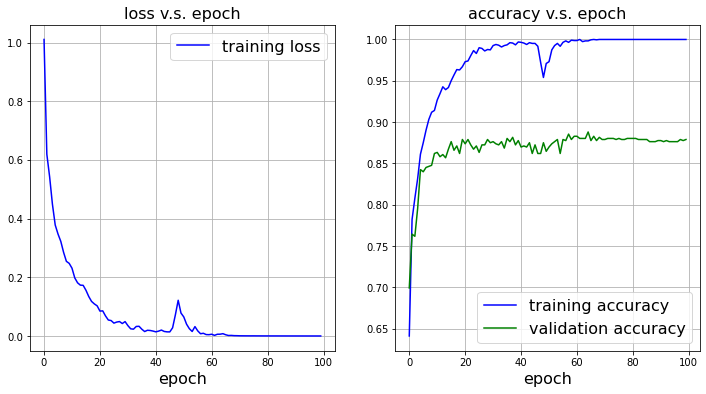

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))
ax[0].set_title('loss v.s. epoch',fontsize=16)
ax[0].plot(loss_train_list, '-b', label='training loss')
ax[0].set_xlabel('epoch',fontsize=16)
ax[0].legend(fontsize=16)
ax[0].grid(True)
ax[1].set_title('accuracy v.s. epoch',fontsize=16)
ax[1].plot(acc_train_list, '-b', label='training accuracy')
ax[1].plot(acc_val_list, '-g', label='validation accuracy')
ax[1].set_xlabel('epoch',fontsize=16)
ax[1].legend(fontsize=16)
ax[1].grid(True)


In [21]:
best_epoch=np.argmax(acc_val_list)
best_epoch

64

In [22]:
# testing acc

model.eval()
running_corrects = 0

for inputs, labels in loader_test:
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

    running_corrects += torch.sum(preds == labels.data)

test_acc = running_corrects.double() / len(loader_test.dataset)
print(f'Test Acc: {test_acc:.4f}')


Test Acc: 0.8752
